#### For Colab

In [1]:
"""
function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button").click() 
}
var i = setInterval(ClickConnect, 900000)
clearInterval(i)
"""

'\nfunction ClickConnect(){\n    console.log("Working");\n    document.querySelector("colab-toolbar-button").click() \n}\nvar i = setInterval(ClickConnect, 900000)\nclearInterval(i)\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
drive_dir = '/content/drive/My Drive/MAGMA: Summarization/'

#### Install Libraries

In [4]:
!pip install transformers==4.1.1
!pip install -U sentencepiece!=0.1.92
!pip install -U datasets
!pip install rouge_score

     |████████████████████████████████| 1.5MB 12.1MB/s 
     |████████████████████████████████| 890kB 51.2MB/s 
     |████████████████████████████████| 2.9MB 48.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=69e316a9be027f929ee469e0316f9f5259712c4dc17a4fe3e3ea5912cbfa49d2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 11.4MB/s 
     |████████████████████████████████| 163kB 13.1MB/s 
     |████████████████████████████████| 245kB 29.1MB/s 
     |████████████████████████████████| 17.7MB 201kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


### **Config**

In [5]:
import os
import sys

sys.path.insert(0, drive_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
MODEL = 'bart'
MODELS = {}

### **Init**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill

### **Function Definition**

##### Import Model and Tok

In [8]:
def import_model_tok(model_name_or_path):
    global MODELS

    if model_name_or_path in MODELS.keys():
        print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    MODELS[model_name_or_path] = model, tokenizer
    print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Nice Print

In [9]:
def print_example(idx, text, summ, bull):
    print(idx)
    print(fill(text, 150))
    print()
    print('Prediction:')
    print(fill(summ, 100))
    print()
    print('Reference:')
    print(fill(bull, 100))
    print()
    print(''.join(['#']*100))
    print()

##### Print Examples

In [10]:
def print_examples(model_name_or_path, df, n_examples=10):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():

        summ_enc = model.generate(
            tokenizer.encode(row.text, return_tensors='pt').to(device),
            min_length = config.BULLETS_MIN_LEN,
            max_length = config.BULLETS_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)[0]
        summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

        print_example(idx, row.text, summ, row.bullets)

##### Plot Evaluation

In [11]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))

    fig, ax = plt.subplots(figsize=(10, 6))
    box_plt_list = [plt.boxplot(
        [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for r in prf],
        positions= xticks+var,
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True)\
        for rouge, var in zip(config.ROUGE_TYPES,
            np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge))]

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **LDA**

In [ ]:
# Output path
if 'bart' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_topic_modeling/bart/lda/'

    OUTPUT_PATH = drive_dir+'summarization/topic_modeling_output/bart/lda/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
elif 'pegasus' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_topic_modeling/pegasus/lda/'

    OUTPUT_PATH = drive_dir+'summarization/topic_modeling_output/pegasus/lda/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

In [ ]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter']).rename(columns={'lda_reduction': 'text'})
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter']).rename(columns={'lda_reduction': 'text'})
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter']).rename(columns={'lda_reduction': 'text'})

### **Print and Summarization**

##### Print Train Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_train)

[*] importing the model




[+] the model is now present in cache

(9781910797150, 'ch04')
It is essential that oncologists and oncology practitioners take significant time and effort to prepare patients adequately for their first course of
chemotherapy . Clinicians have a wide variety of antiemetics to choose from for the prevention of chemotherapy-induced nausea and vomiting (CINV), and
patients should receive the most effective antiemetic agents available . Outcomes are improved by following the recommendations of national or
international guidelines for CINV . If antiemetic therapy is used correctly, CINV can be prevented in up to 70-75% of patients receiving highly
emetogenic chemotherapy (HEC) and up to 80% receiving moderately emetogenic chemotherapy (MEC) . If the patient has a high level of anxiety before the
first course of chemotherapy, serious consideration should be given to adding an antianxiety agent to the antiemetic regimen . Antiemetic therapy
should be started before chemotherapy is administer

##### Print Val Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_val)

[+] model already present in cache

(9781910797471, 'ch02')
Advances in the management of heart failure (HF) over the past 20 years have been informed by a better understanding of its pathophysiology . HF is a
disease of inappropriate adaptation to injury . In general, however, these adjustments to hypovolemia are poorly suited to pump failure, and increases
in the preload and afterload of the failing heart lead to worsening HF (Figure 2.1) . Neurohormonal pathways activated in HF include the sympathetic
nervous system (SNS), the renin-angiotensin-aldosterone system (RAAS) and the natriuretic peptide (NP) system . They play a significant role in the
pathophysiology of HF, and pharmacological interventions have been developed accordingly (see Chapter 7) . Sympathetic nervous system . Sympathetic
activation of the adrenergic system leads to vasoconstriction, which increases the resistance to blood flow and helps to maintain arterial pressure in
the early stages of HF when cardiac output 

##### Print Test Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_test)

[+] model already present in cache

(9781910797105, 'ch05')
Is schizophrenia a degenerative brain disorder, as originally thought by Kraepelin, or is it better viewed as non-progressive? . During the 1990s,
much attention was given to the 'neurodevelopmental hypothesis' of schizophrenia . On the basis of the range of observations outlined in Table 5.1, it
was suggested that a static lesion, either genetic or environmental in origin during brain development, expressed its effects as a function of the
maturational stage of the brain . In schizophrenia, the characteristic symptoms emerge only during the final stages of brain development in
adolescence, when normal 'pruning' or elimination of excess synapses takes place . It is now known that schizophrenia results in part from a
developmentally regulated disconnection of higher order association areas, through alterations in neuronal migration, synapse formation and
myelination . Neurodevelopmental risk factors . Some established risk fact

##### Summarize Test

In [ ]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.BULLETS_MIN_LEN,
            max_length = config.BULLETS_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [ ]:
df_test = summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

[+] model already present in cache

100%|██████████| 5/5 [00:32<00:00,  6.44s/it]


### **Evaluation**

In [ ]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [ ]:
def evaluate_model(df, model_name_or_path):
    rouge_res =\
        df[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
    
    df_save = df[[c for c in df_test.columns if c.startswith('rouge')]]
    df_save.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [ ]:
df_test = evaluate_model(df_test, 'sshleifer/distilbart-cnn-12-6')

##### Plot Evaluation

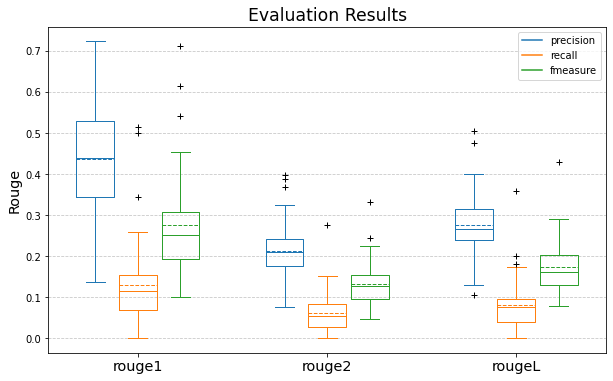

In [ ]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')

## **LSI**

In [ ]:
# Output path
if 'bart' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_topic_modeling/bart/lsi/'

    OUTPUT_PATH = drive_dir+'summarization/topic_modeling_output/bart/lsi/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
elif 'pegasus' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_topic_modeling/pegasus/lsi/'

    OUTPUT_PATH = drive_dir+'summarization/topic_modeling_output/pegasus/lsi/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

In [ ]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter']).rename(columns={'lsi_reduction': 'text'})
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter']).rename(columns={'lsi_reduction': 'text'})
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter']).rename(columns={'lsi_reduction': 'text'})

### **Print and Summarization**

##### Print Train Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_train)

[+] model already present in cache

(9781910797150, 'ch04')
It is essential that oncologists and oncology practitioners take significant time and effort to prepare patients adequately for their first course of
chemotherapy . Outcomes are improved by following the recommendations of national or international guidelines for CINV . All of the guidance for
managing CINV in this book adheres to these international guidelines . Management principles . The route of delivery will depend on what the patient
is best able to tolerate . In general, antiemetics given either orally or intravenously in appropriate doses have equivalent efficacy . Highly
emetogenic chemotherapy . The recommended doses for these agents are shown in Table 4.3 . Women with breast cancer receiving AC chemotherapy have a
particularly high risk of CINV and are included in these recommendations . Choice of antiemetic agent . Many clinical institutions have pharmacy
committees that provide recommendations or formularies for s

##### Print Val Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_val)

[+] model already present in cache

(9781910797471, 'ch02')
HF is a disease of inappropriate adaptation to injury . The body has a limited range of compensatory responses to circulatory impairment, mainly
vasoconstriction and sodium and water retention (see below) . In general, however, these adjustments to hypovolemia are poorly suited to pump failure,
and increases in the preload and afterload of the failing heart lead to worsening HF (Figure 2.1) . Neurohormonal pathways activated in HF include the
sympathetic nervous system (SNS), the renin-angiotensin-aldosterone system (RAAS) and the natriuretic peptide (NP) system . Sympathetic nervous system
. Sympathetic activation of the adrenergic system leads to vasoconstriction, which increases the resistance to blood flow and helps to maintain
arterial pressure in the early stages of HF when cardiac output is reduced . However, vasoconstriction also increases the afterload on the heart,
leading to a worsening of HF (see Figure 2.1) . Enha

##### Print Test Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_test)

[+] model already present in cache

(9781910797105, 'ch05')
Is schizophrenia a degenerative brain disorder, as originally thought by Kraepelin, or is it better viewed as non-progressive? . During the 1990s,
much attention was given to the 'neurodevelopmental hypothesis' of schizophrenia . On the basis of the range of observations outlined in Table 5.1, it
was suggested that a static lesion, either genetic or environmental in origin during brain development, expressed its effects as a function of the
maturational stage of the brain . In schizophrenia, the characteristic symptoms emerge only during the final stages of brain development in
adolescence, when normal 'pruning' or elimination of excess synapses takes place . It is now known that schizophrenia results in part from a
developmentally regulated disconnection of higher order association areas, through alterations in neuronal migration, synapse formation and
myelination . Neurodevelopmental risk factors . Some established risk fact

##### Summarize Test

In [ ]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.BULLETS_MIN_LEN,
            max_length = config.BULLETS_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [ ]:
df_test = summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

[+] model already present in cache

100%|██████████| 5/5 [00:30<00:00,  6.19s/it]


### **Evaluation**

In [ ]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [ ]:
def evaluate_model(df, model_name_or_path):
    rouge_res =\
        df[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
    
    df_save = df[[c for c in df_test.columns if c.startswith('rouge')]]
    df_save.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [ ]:
df_test = evaluate_model(df_test, 'sshleifer/distilbart-cnn-12-6')

##### Plot Evaluation

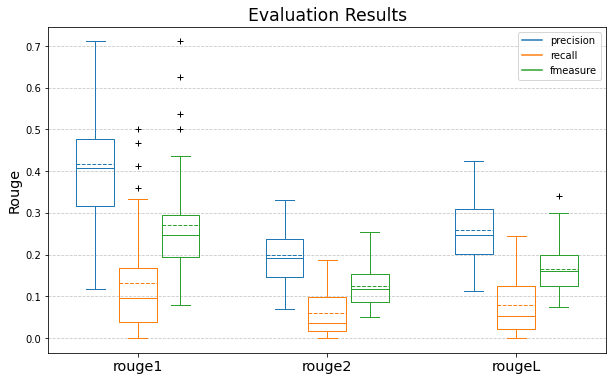

In [ ]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')

## **TestRank**

In [13]:
# Output path
if 'bart' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_topic_modeling/bart/textrank/'

    OUTPUT_PATH = drive_dir+'summarization/topic_modeling_output/bart/textrank/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
elif 'pegasus' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_topic_modeling/pegasus/textrank/'

    OUTPUT_PATH = drive_dir+'summarization/topic_modeling_output/pegasus/textrank/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

In [ ]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter']).rename(columns={'textrank_reduction': 'text'})
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter']).rename(columns={'textrank_reduction': 'text'})
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter']).rename(columns={'textrank_reduction': 'text'})

### **Print and Summarization**

##### Print Train Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_train)

[+] model already present in cache

(9781910797150, 'ch04')
Clinicians have a wide variety of antiemetics to choose from for the prevention of chemotherapy-induced nausea and vomiting (CINV), and patients
should receive the most effective antiemetic agents available . Prophylactic control of acute and delayed CINV that occurs as a result of cisplatin-
or anthracycline and cyclophosphamide (AC)-based chemotherapy or other highly emetogenic chemotherapy (HEC) requires an initial three-drug regimen,
administered before chemotherapy starts on day 1 of treatment (Figures 4.1 and 4.2) . This should include a 5-HT receptor antagonist (RA)
(granisetron, ondansetron, tropisetron, dolasetron or palonosetron; see pages 25-34), dexamethasone (see page 43) and a neurokinin (NK)-1 RA
(aprepitant, fosaprepitant, rolapitant or netupitant/NEPA; see pages 34-43) . Two studies have compared the second-generation 5-HT RA palonosetron
with ondansetron and granisetron in the prevention of cisplatin-induced 

##### Print Val Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_val)

[+] model already present in cache

(9781910797471, 'ch02')
In general, however, these adjustments to hypovolemia are poorly suited to pump failure, and increases in the preload and afterload of the failing
heart lead to worsening HF (Figure 2.1) . Neurohormonal pathways activated in HF include the sympathetic nervous system (SNS), the renin-angiotensin-
aldosterone system (RAAS) and the natriuretic peptide (NP) system . Sympathetic activation of the adrenergic system leads to vasoconstriction, which
increases the resistance to blood flow and helps to maintain arterial pressure in the early stages of HF when cardiac output is reduced . However,
vasoconstriction also increases the afterload on the heart, leading to a worsening of HF (see Figure 2.1) . Angiotensin II causes systemic
vasoconstriction and acts on the adrenal cortex to produce aldosterone, leading to sodium and water retention . Sympathetic stimulation also releases
antidiuretic hormone, which leads to retention of free wat

##### Print Test Examples

In [ ]:
print_examples('sshleifer/distilbart-cnn-12-6', df_test)

[+] model already present in cache

(9781910797105, 'ch05')
Developmental theories and environmental factors . Is schizophrenia a degenerative brain disorder, as originally thought by Kraepelin, or is it better
viewed as non-progressive? On the basis of the range of observations outlined in Table 5.1, it was suggested that a static lesion, either genetic or
environmental in origin during brain development, expressed its effects as a function of the maturational stage of the brain . In schizophrenia, the
characteristic symptoms emerge only during the final stages of brain development in adolescence, when normal 'pruning' or elimination of excess
synapses takes place . It is now known that schizophrenia results in part from a developmentally regulated disconnection of higher order association
areas, through alterations in neuronal migration, synapse formation and myelination . Neurodevelopmental risk factors . Some established risk factors
act early in life (Table 5.2) . Obstetric compli

##### Summarize Test

In [ ]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.BULLETS_MIN_LEN,
            max_length = config.BULLETS_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [ ]:
df_test = summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

[+] model already present in cache

100%|██████████| 5/5 [00:30<00:00,  6.02s/it]


### **Evaluation**

In [ ]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [ ]:
def evaluate_model(df, model_name_or_path):
    rouge_res =\
        df[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
    
    df_save = df[[c for c in df_test.columns if c.startswith('rouge')]]
    df_save.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [ ]:
df_test = evaluate_model(df_test, 'sshleifer/distilbart-cnn-12-6')

##### Plot Evaluation

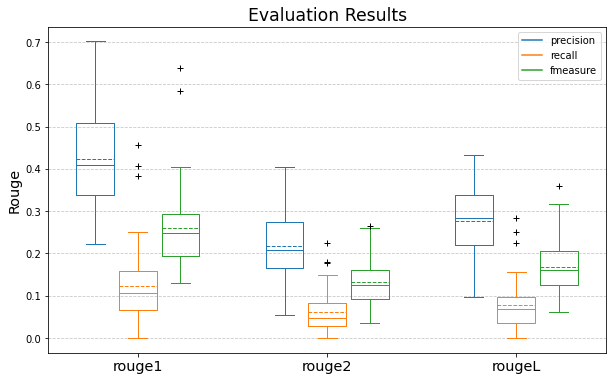

In [14]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')